In [ ]:
import tarfile
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from sklearn import set_config
from pylab import rcParams
from scipy.stats import randint
from google.colab import files
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rc('font', size=8)
plt.rc('axes', labelsize=8, titlesize=14)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)



#Download Data

In [ ]:
def load_data():
    tarball_path = Path("datasets/googleplaystore.csv")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        files.upload()
        ! mkdir ~/.kaggle
        ! cp kaggle.json ~/.kaggle/
        ! chmod 600 ~/.kaggle/kaggle.json
        !kaggle datasets download -d lava18/google-play-store-apps
        !unzip google-play-store-apps.zip -d datasets
        
    return pd.read_csv(Path("datasets/googleplaystore.csv"))

appdata = load_data()

# Quick Look at data

In [ ]:
appdata.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
appdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [ ]:
from IPython.display import display

cols=["Category","Rating","Installs","Type","Content Rating","Genres","Current Ver","Android Ver"]
for col in cols:
  display(pd.DataFrame(appdata[col].value_counts()).T)
  print("\n"+"_"*150)

,FAMILY,GAME,TOOLS,MEDICAL,BUSINESS,PRODUCTIVITY,PERSONALIZATION,COMMUNICATION,SPORTS,LIFESTYLE,FINANCE,HEALTH_AND_FITNESS,PHOTOGRAPHY,SOCIAL,NEWS_AND_MAGAZINES,SHOPPING,TRAVEL_AND_LOCAL,DATING,BOOKS_AND_REFERENCE,VIDEO_PLAYERS,EDUCATION,ENTERTAINMENT,MAPS_AND_NAVIGATION,FOOD_AND_DRINK,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,AUTO_AND_VEHICLES,WEATHER,ART_AND_DESIGN,EVENTS,PARENTING,COMICS,BEAUTY,1.9
Category,1972,1144,843,463,460,424,392,387,384,382,366,341,335,295,283,260,258,234,231,175,156,149,137,127,88,85,85,82,65,64,60,60,53,1



______________________________________________________________________________________________________________________________________________________


,4.4,4.3,4.5,4.2,4.6,4.1,4.0,4.7,3.9,3.8,5.0,3.7,4.8,3.6,3.5,3.4,3.3,4.9,3.0,3.1,3.2,2.9,2.8,2.7,2.6,2.5,2.3,2.4,1.0,2.2,1.9,2.0,1.7,1.8,2.1,1.6,1.4,1.5,1.2,19.0
Rating,1109,1076,1038,952,823,708,568,499,386,303,274,239,234,174,163,128,102,87,83,69,64,45,42,25,25,21,20,19,16,14,13,12,8,8,8,4,3,3,1,1



______________________________________________________________________________________________________________________________________________________


,"1,000,000+","10,000,000+","100,000+","10,000+","1,000+","5,000,000+",100+,"500,000+","50,000+","5,000+","100,000,000+",10+,500+,"50,000,000+",50+,5+,"500,000,000+",1+,"1,000,000,000+",0+,0,Free
Installs,1579,1252,1169,1054,907,752,719,539,479,477,409,386,330,289,205,82,72,67,58,14,1,1



______________________________________________________________________________________________________________________________________________________


,Free,Paid,0
Type,10039,800,1



______________________________________________________________________________________________________________________________________________________


,Everyone,Teen,Mature 17+,Everyone 10+,Adults only 18+,Unrated
Content Rating,8714,1208,499,414,3,2



______________________________________________________________________________________________________________________________________________________


,Tools,Entertainment,Education,Medical,Business,Productivity,Sports,Personalization,Communication,Lifestyle,Finance,Action,Health & Fitness,Photography,Social,News & Magazines,Shopping,Travel & Local,Dating,Books & Reference,Arcade,Simulation,Casual,Video Players & Editors,Puzzle,Maps & Navigation,Food & Drink,Role Playing,Strategy,Racing,House & Home,Libraries & Demo,Auto & Vehicles,Weather,Adventure,Events,Comics,Art & Design,Beauty,Education;Education,Card,Parenting,Board,Educational;Education,Casino,Trivia,Educational,Casual;Pretend Play,Word,Entertainment;Music & Video,Education;Pretend Play,Music,Casual;Action & Adventure,Racing;Action & Adventure,Puzzle;Brain Games,Educational;Pretend Play,Action;Action & Adventure,Arcade;Action & Adventure,Board;Brain Games,Casual;Brain Games,Adventure;Action & Adventure,Simulation;Action & Adventure,Entertainment;Brain Games,Parenting;Education,Role Playing;Action & Adventure,Casual;Creativity,Art & Design;Creativity,Education;Creativity,Education;Action & Adventure,Educational;Brain Games,Parenting;Music & Video,Education;Music & Video,Puzzle;Action & Adventure,Educational;Creativity,Role Playing;Pretend Play,Education;Brain Games,Educational;Action & Adventure,Sports;Action & Adventure,Simulation;Pretend Play,Casual;Education,Music;Music & Video,Board;Action & Adventure,Video Players & Editors;Music & Video,Entertainment;Action & Adventure,Simulation;Education,Entertainment;Creativity,Art & Design;Action & Adventure,Books & Reference;Education,Card;Action & Adventure,Adventure;Education,Video Players & Editors;Creativity,Entertainment;Pretend Play,Casual;Music & Video,Puzzle;Creativity,Art & Design;Pretend Play,Strategy;Action & Adventure,"February 11, 2018",Strategy;Education,Trivia;Education,Communication;Creativity,Role Playing;Brain Games,Racing;Pretend Play,Role Playing;Education,Puzzle;Education,Adventure;Brain Games,Books & Reference;Creativity,Lifestyle;Education,Entertainment;Education,Health & Fitness;Action & Adventure,Parenting;Brain Games,Tools;Education,Travel & Local;Action & Adventure,Board;Pretend Play,Health & Fitness;Education,Music & Audio;Music & Video,Arcade;Pretend Play,Card;Brain Games,Lifestyle;Pretend Play,Comics;Creativity,Strategy;Creativity
Genres,842,623,549,463,460,424,398,392,387,381,366,365,341,335,295,283,260,257,234,231,220,200,193,173,140,137,127,109,107,98,88,85,85,82,75,64,59,58,53,50,48,46,44,41,39,38,37,31,29,27,23,22,21,20,19,19,17,16,15,13,13,11,8,7,7,7,7,7,6,6,6,5,5,5,5,5,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



______________________________________________________________________________________________________________________________________________________


,Varies with device,1.0,1.1,1.2,2.0,1.3,1.0.0,1.0.1,1.4,1.5,1.0.2,1.6,1.0.3,2.1,3.0,1.0.4,1.7,2.0.0,1.0.5,1.1.0,1.1.1,1.0.6,1.2.1,1.2.0,1.8,4.0,1.9,2.3.2,2.4,1.0.7,1.0.9,2.2,1.1.2,2.0.1,5.0,3.1,1.4.0,2.5,1.1.3,3.0.0,1.0.8,2.3,1.3.0,1,1.2.2,4.1,1.1.4,5.1,2.1.1,1.2.3,8.2,3.3,2.6,6.0,1.3.1,2.1.0,3.1.0,1.5.0,1.01,1.1.6,4.2.2,2.4.0,2.0.5,1.6.1,3.0.1,2.9,2.1.2,1.1.5,2.7,2.5.1,1.5.1,3.2,2.4.1,0.0.1,3.1.4,2.0.7,1.03,2.8,3.8.0,2,1.1.7,1.6.2,1.5.2,5.2,1.11,1.2.6,1.0.11,3.5,0.1,1.2.7,8.0,4.1.0,3.0.2,2.1.3,1.3.3,3.1.1,1.10,1.2.9,2.2.1,2.3.1,3.6.1,2.0.4,3.0.5,2.0.3,1.02,5.9.1.0,4.2.1,2.1.4,2.0.2,1.1.8,7.0,1.3.2,1.6.0,4.5.2,1.8.1,1.2.5,2.2.0,1.17,3.2.0,4.17.2,1.7.2,3.4,2.2.2,1.8.2,1.0.10,1.3.4,1.2.4,3.6,11.45.0,4.1.1,2.9.0,1.7.0,5.3,1.4.1,1.4.6,1.05,3.9,1.7.1,1.8.0,300000.1.11,6.1,1.6.7.1,4.2,2.3.0,3.4.5,4.4.1,3.1.2,5.0.0,3.7,2.1.5,3.8,1.8.19106,4.0.0,1.4.4,1.7.3,3.0.6,2.347.225742,3.2.1,1.12,2.4.4,1.3.6,18.7.1,1.3.5,4.0.2,2.0.8,2.4.2,1.06,1.08,9.0,1.07,4.4,4.7.0,1.0.16,1.4.2,2.8.0,1.24,2.6.0,6.1.7,3.1.3,1.14,1.8.3,3.4.0,3.2.5,6.1.3,3.0.4,4.2.0,4.3,2.5.0,Android 3.0 - 2015,1.129.0.2,8.1,2.3.5,1.04,4.0.1,1.1.9,6.0.0,3.5.0,1.9.7,1.9.1,3.3.0,1.7.7,1.18,2.3.3,2.17,2.12.5,5.0.1,1.0.27,1.6.5,1.49.1,4.1.2,5.4,4.6.0,2.1.8,2.5.2,3,2.3.4,1.3.7,1.4.3,1.20,6.0.1,1.90.0,3.9.2,6.2.0,2.2.7,1.6.3,18.1.79,2.2.4,1.0.12,2.6.1,3.4.4,3.1.9,1.28,2.2.5,7.6.5,4.2.3,7.2,4.0.5,4.3.0,6.5.1,1.6.4,3.0.3,1.11.0,5.3.0,4.6.2,4.0.3,2.8.2,8.25.10.00,4.5.1,5.13.1,7,10,3.8.8,5.0.4,5.33.3669,1.13,16.0.10325.20043,1.4.9,0.0.9,2.2.8,2.9.1,2.0.9,7.5.0,1.0.15,2.10,4.7,1.31,3.7.1,2.2.9,3.52,7.4,1.9.0,7.0.1,20.7.2,3.5.3,1.00,4.0.4,1.0.21,14.0,4.6,3.2.7,1.0.0.0,5.2.1,6.9.031,4.4.4,5.3.1,1.32,4.5,6.17.2,1.40,1.5.4,1.21.0,2.7.0,5.1.1,4.20.5,7.9.3,1.4.0.1,2.2.3,1.2.8,5.48,7.2.2,2.2.00,6.7.0,Cow V3.15,5.2.2,7.8.0,0.0.2,0.8,5.1.0,300000.0.97,6.5.3,1.4.5,1.22,1.95,"1,01",4.10.0,2.17.0,3.0.10,4.3.6,2.70.206190089,1.0.23,3.3.6,4,1.26,2.18,12,3.1.6z,1.0.19,5.14.0,2.14,5.5,6.5,2.1.10,1.37.2,5.1.8,3.7.2.51,1.0.47,2.8.2.59,2.10.2,4.7.4,2.1.9,0.7.0,7.2.1,1.9.3,3.6.0,2.25.17,3.10.26,4.4.3,1.8.4,4.0.9,6.6,4.4.7,8.0.226,6.2,1.17.0,6.4.0,9.1.4,5.13.007,2.6.3,7.1,6.7.5,10.0,7.2.5,3.2.2,5.7,1.6.7,5.2.0,3.1.7,4.1.4,3.2.4,2.5.9,4.4.2,18.0,1.283.0037,10.322.16,1.19,5.1.2,4.0.6,9.7.753080,1.5.3,2.2.6,3.1.8,6.7.1,1.20.1,18.30.0,1.4.77,2.6.9,3.3.1,1.39,3.5.2,4.3.2,1.3.8,3.0.7,9.8.000000010501,2.9.8,2.6.2,3.9.1,6.1.2,4.5.4,2.6.6,15.0,13.9.0.161,3.43.3,5.20.7,7.5.3.20547,1.16,3.4.2,1.31.3,1.10.0,4.20,1.15,3.4.6,1.12.0,11.10.1,5.064,3.5.0.1,2.0.6,20,1.38,6.2.73,11.0,1.9.2,6.1.0,5.0.16,6.7,4.3.0.508,4.5.0,6.3.3,2.7.6,3.48,1.37,14,3.2.3,6.0.3,1.7.14,1.35,5.5.2,v1.0,2.0.20,5.7.2,4.4.15,18.7,3.9.7,47.1.2249.129326,1.5.8,2.4.11,4.9.1,2.7.36,2.22,2.15.1,3.7.5,6.15.0,9.3.1,2.1.7,4.3.1,5.29.3,4.8.0,3.8.2,1.6.6,0.1.1,4.8.4,1.1.10,2.1.6,2.2.3181,3.9.3,2.7.8,3.8.75a,6.25.0+1906001476,5.3.4,4.7.3,1.118.4,1.4.8,5.0.6,4.7.1,3.2.6,1.0.28,4.2.4,5.1.4,16.14.0.100,1.23.3.0,7.5.9.1,11.0.0,2.16,3.8.1,2.12.0,1.29,2.4.3,4.8.0.132,3.7.2,4.47,6.3.1,3.1.5,1.43.3,5.9.0,2.20,1.751,1.,22.0,1.8.5,3196,5.0.8,1.53,4.8.5,2.0.10,43.0,1.22.0,0.0.4,4.5.5,4.4.9,5.6.8,5.66,3.13.09,2.21.5,6.3.7,18.10.157066,7.12,7.3(800241),1.17.2,3.10,3.3.2,2.8.4,1.7.5,3.9.4,4.6.4,4.21.1,2.7.2,6.19.5,4.9.10,8.18,1.0.13,1.11.2,2018.5.47,4.8.1,1.10.1,1.21.2,2.19.0.204537701,2.7.4,1.33,0.99,20.0,11.4.0,4.9,1.51,5.7.0,5.7.1,1.57,2.4.9,1.73,1.3.9,1.21,6,7.3,1.2.3-play,2.9.4,1.0.209,5.17,1.4.7,5,3.3.1.41,6.6.1,5.5.0,2.13.5,12.8.2,1.0.20,10.0.3086,37893,12.8.5.1121,4.1.8.2.2,1.4.12,16.0.10325.20024,2.3.9,1.8.6,1.14.0,0.0.7,3.6.2,6.0.2,1.48,4.1.3,1.25,6.0.4,6.8.2,4.4.5,6.02.000,2.12,1.52,1.50,2.9.5,3.19,6.2.3,1.54,0.0.5,1.7.6,2.28,1.23,4.38.176,2.25.0,0.2.7,3.19.34,3.52.1,1.16.0,2.1.35,1.0.02,1.278.0037,1.0.3386,5.11,8.8,3.27.3,1.47,1.8.19179,5.9.6,1.1.14,1.2.A.Exceed.Paid,0.1.100944346,2.11.0,42.0.0.2059,7.3.1,4.1.202,4.81,69.0.3497.24,2.1.20,3.1.7z,9.9.0,6.7.5222,1.28.01,13.0,2.1.18,2.4.12,3.2.0h,10.0.0,2.4.25,3.4.1,6.14.091,4.5.3,7.4.1,10.4.1.000_00,7.2.0,1.0.2.1,1.10.


______________________________________________________________________________________________________________________________________________________


,4.1 and up,4.0.3 and up,4.0 and up,Varies with device,4.4 and up,2.3 and up,5.0 and up,4.2 and up,2.3.3 and up,2.2 and up,4.3 and up,3.0 and up,2.1 and up,1.6 and up,6.0 and up,7.0 and up,3.2 and up,2.0 and up,5.1 and up,1.5 and up,4.4W and up,3.1 and up,2.0.1 and up,8.0 and up,7.1 and up,4.0.3 - 7.1.1,5.0 - 8.0,1.0 and up,7.0 - 7.1.1,4.1 - 7.1.1,5.0 - 6.0,2.2 - 7.1.1,5.0 - 7.1.1
Android Ver,2451,1501,1375,1362,980,652,601,394,281,244,243,241,134,116,60,42,36,32,24,20,12,10,7,6,3,2,2,2,1,1,1,1,1



______________________________________________________________________________________________________________________________________________________


In [ ]:
pd.DataFrame(appdata["Category"].value_counts()).T

,FAMILY,GAME,TOOLS,MEDICAL,BUSINESS,PRODUCTIVITY,PERSONALIZATION,COMMUNICATION,SPORTS,LIFESTYLE,FINANCE,HEALTH_AND_FITNESS,PHOTOGRAPHY,SOCIAL,NEWS_AND_MAGAZINES,SHOPPING,TRAVEL_AND_LOCAL,DATING,BOOKS_AND_REFERENCE,VIDEO_PLAYERS,EDUCATION,ENTERTAINMENT,MAPS_AND_NAVIGATION,FOOD_AND_DRINK,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,AUTO_AND_VEHICLES,WEATHER,ART_AND_DESIGN,EVENTS,PARENTING,COMICS,BEAUTY,1.9
Category,1972,1144,843,463,460,424,392,387,384,382,366,341,335,295,283,260,258,234,231,175,156,149,137,127,88,85,85,82,65,64,60,60,53,1


In [ ]:
t_df=appdata["Type"].value_counts()
pd.DataFrame(t_df).T

,Free,Paid,0
Type,10039,800,1


In [ ]:
t_df=appdata["Content Rating"].value_counts()
pd.DataFrame(t_df).T

,Everyone,Teen,Mature 17+,Everyone 10+,Adults only 18+,Unrated
Content Rating,8714,1208,499,414,3,2


In [ ]:
t_df=appdata["Content Rating"].value_counts()
pd.DataFrame(t_df).T

,Everyone,Teen,Mature 17+,Everyone 10+,Adults only 18+,Unrated
Content Rating,8714,1208,499,414,3,2


In [ ]:
def nullcount(df):
  vals={}
  for col in df.columns:
    vals[col]=df[col].isnull().sum()

  return vals

nullcount(appdata)

{'App': 0,
 'Category': 0,
 'Rating': 1474,
 'Reviews': 0,
 'Size': 0,
 'Installs': 0,
 'Type': 1,
 'Price': 0,
 'Content Rating': 1,
 'Genres': 0,
 'Last Updated': 0,
 'Current Ver': 8,
 'Android Ver': 3}

In [ ]:
# save charts
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
appdata.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


#Clean Data

#Create a Test Set

In [ ]:

appdata = appdata.dropna()

In [ ]:
appdata["rating_cat"]=pd.cut(appdata["Rating"],
                               bins=[-np.inf,1.0, 2.0, 3.0, 4.0, np.inf],
                               labels=[1,2, 3, 4, 5])

<ipython-input-239-24960dc3b8b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appdata["rating_cat"]=pd.cut(appdata["Rating"],


In [ ]:
# appdata["rating_cat"].value_counts().sort_index().plot(rot=0, kind='bar', grid=True)
# plt.xlabel("Rating category")
# plt.ylabel("Number of Apps")
# #save_fig("housing_income_cat_bar_plot")  # extra code
# plt.show()

In [ ]:
nullcount(appdata)["rating_cat"]<=0

True

In [ ]:

strat_train_set, strat_test_set = train_test_split(
    appdata, test_size=0.2, stratify=appdata["rating_cat"], random_state=42)

#Discover and Visualize the Data to Gain Insights

In [ ]:
#outlier in rating
strat_train_set["Rating"]=strat_train_set["Rating"].apply(lambda x: x/10 if x>10 else x)


Text(0.5, 1.0, 'Boxplot of Rating VS Category')

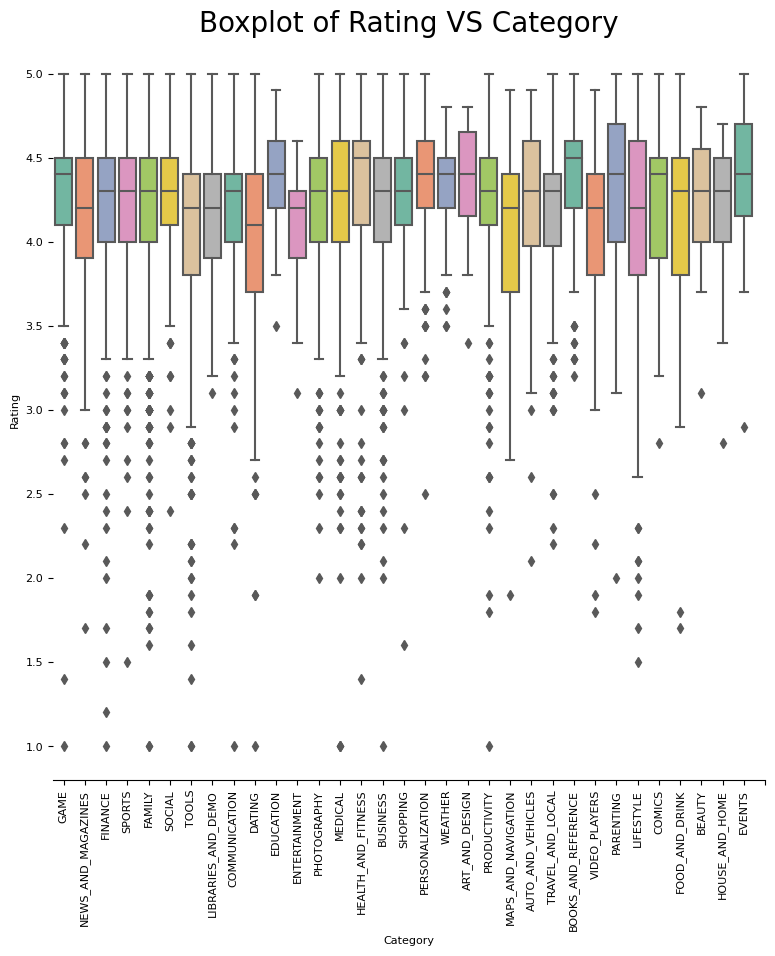

In [ ]:

fig = sns.catplot(x="Category",y="Rating",data=strat_train_set, kind="box", height = 8 ,
palette = "Set2")
fig.despine(left=True)
fig.set_xticklabels(rotation=90)
fig.set( xticks=range(0,34))
fig = fig.set_ylabels("Rating")
plt.title('Boxplot of Rating VS Category',size = 20)

Text(0.5, 1.0, 'Distribution of Rating')

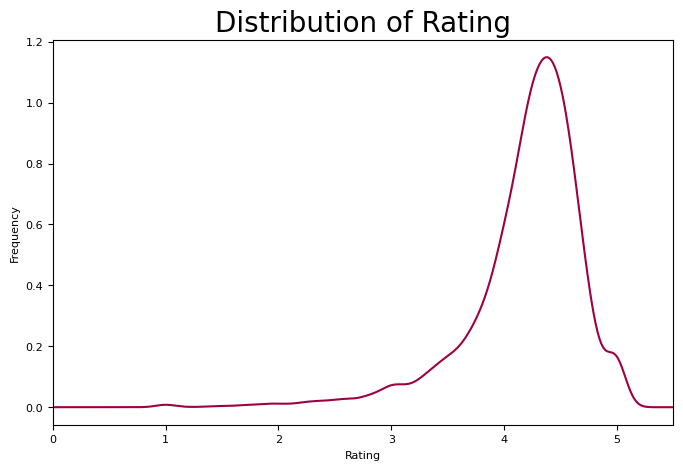

In [ ]:

# rating distibution
cmap = cm.get_cmap('Spectral')

fig=strat_train_set["Rating"].plot( kind='kde',figsize=(8,5), colormap=cmap, xlim=(0,5.5))
fig.set_xlabel("Rating")
fig.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

Text(0, 0.5, 'Frequency')

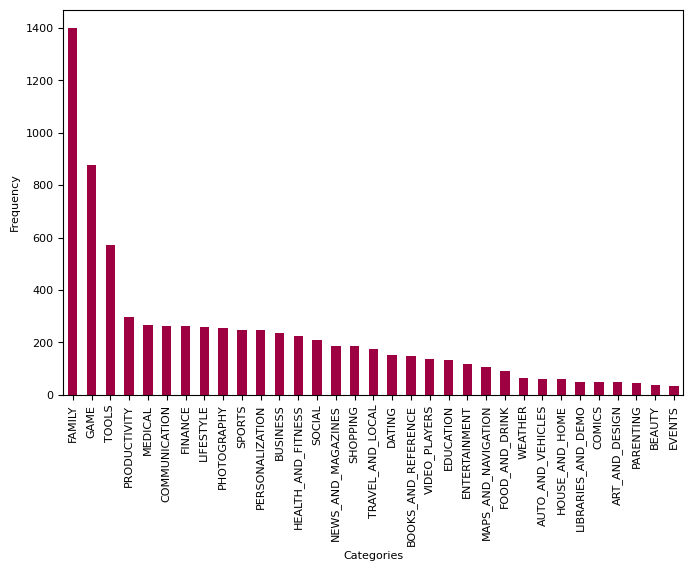

In [ ]:
#barchart for category

cat_=strat_train_set["Category"].value_counts()
fig=cat_.plot( kind='bar',figsize=(8,5), legend=False, colormap=cmap)
fig.set_xlabel("Categories")
fig.set_ylabel("Frequency")

In [ ]:
len(strat_train_set["Type"].value_counts())

2

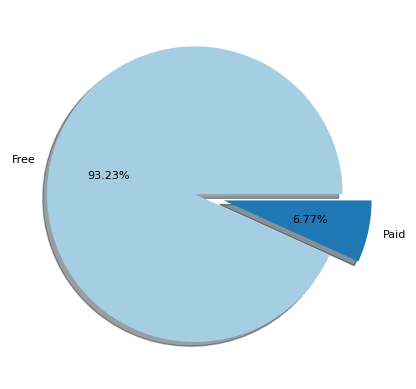

In [ ]:

#define Seaborn color palette to use
y = strat_train_set["Type"].value_counts()
label = strat_train_set["Type"].unique()

colors = sns.color_palette('Paired')[0:3]
explode=[i/5 for i in range(len(strat_train_set["Type"].value_counts()))]

#create pie chart
plt.pie(y, labels = label, colors = colors, autopct='%.02f%%', shadow=True, explode=explode)
plt.show()

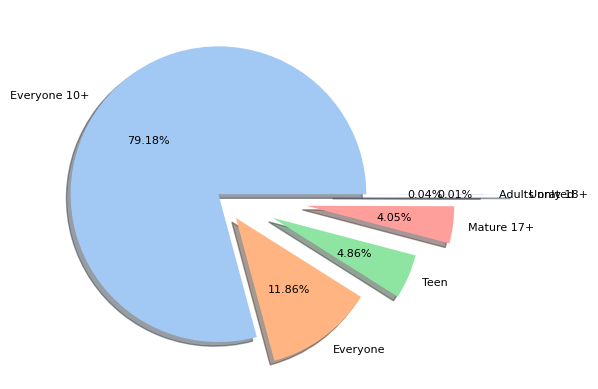

In [ ]:

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]
y = strat_train_set["Content Rating"].value_counts()
label = strat_train_set["Content Rating"].dropna().unique()

explode=[i/5 for i in range(len(strat_train_set["Content Rating"].value_counts()))]

#create pie chart
plt.pie(y, labels = label, colors = colors, autopct='%.02f%%', shadow=True, explode=explode)
plt.show()


#Cleaning Data

In [ ]:
strat_train_set["Installs"]=strat_train_set["Installs"].apply(lambda x: int(x.split("+")[0].replace(",","")) if x!="Free" else 0)

In [ ]:
strat_train_set["Size"].replace('Varies with device', np.nan, inplace = True ) 
strat_train_set["Size"] = (strat_train_set["Size"].replace(r'[kM]+$', '', regex=True).astype(float) * \
             strat_train_set["Size"].str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))

strat_train_set['Size'].fillna(strat_train_set.groupby('Category')['Size'].transform('mean'),inplace = True)

In [ ]:
strat_train_set["Reviews"] = strat_train_set["Reviews"].apply(lambda x: int(x))

In [ ]:
strat_train_set["Price"] = strat_train_set["Price"].apply(lambda x: float(x.replace("$","")) if x!="Free" else 0)

In [ ]:
strat_train_set["Last Updated"] = pd.to_datetime(appdata["Last Updated"])

In [ ]:

strat_train_set["Genres"] = strat_train_set["Genres"].apply(lambda x: x.split(";")[0]) 
strat_train_set["Genres_2"] = strat_train_set["Genres"].apply(lambda x: x.split(";")[-1]) 

In [ ]:
strat_train_set.drop(['App','Last Updated','Current Ver','Android Ver'],axis=1,inplace=True)

In [ ]:
strat_train_set.dtypes

Category            object
Rating             float64
Reviews              int64
Size               float64
Installs             int64
Type                object
Price              float64
Content Rating      object
Genres              object
rating_cat        category
Genres_2            object
dtype: object

In [ ]:
strat_train_set.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,rating_cat,Genres_2
1653,GAME,4.5,4447388,6.700000e+07,100000000,Free,0.0,Everyone 10+,Adventure,5,Adventure
3767,NEWS_AND_MAGAZINES,4.4,1284017,1.316241e+07,500000000,Free,0.0,Everyone 10+,News & Magazines,5,News & Magazines
1175,FINANCE,4.1,6998,2.400000e+07,1000000,Free,0.0,Everyone,Finance,5,Finance
3088,SPORTS,4.3,7543,2.500000e+07,500000,Free,0.0,Everyone,Sports,5,Sports
3947,FAMILY,3.9,31061,8.300000e+07,1000000,Free,0.0,Everyone,Health & Fitness,4,Health & Fitness


<ipython-input-260-b1cc887252fc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(strat_train_set.corr(), annot=True, cmap='Reds')


<Axes: >

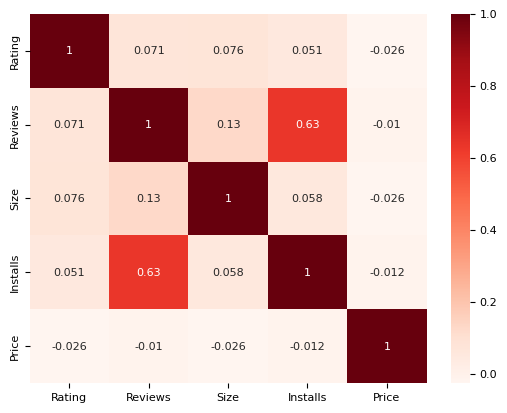

In [ ]:
 sns.heatmap(strat_train_set.corr(), annot=True, cmap='Reds')

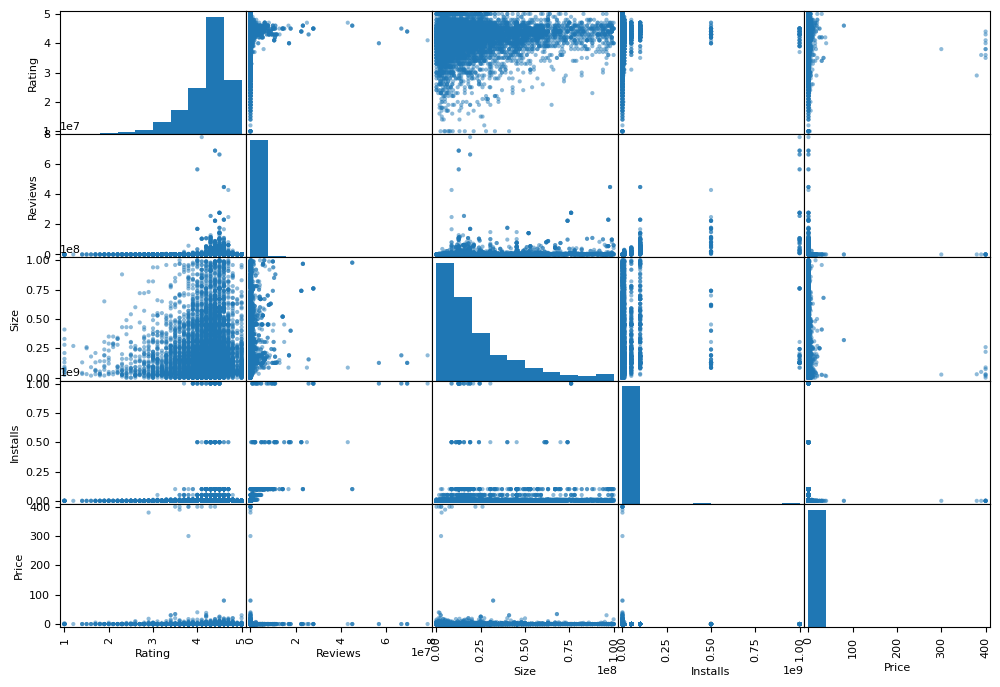

In [ ]:

scatter_matrix(strat_train_set, figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

#Feature Engg

In [ ]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7488 entries, 1653 to 1432
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Category        7488 non-null   object  
 1   Rating          7488 non-null   float64 
 2   Reviews         7488 non-null   int64   
 3   Size            7488 non-null   float64 
 4   Installs        7488 non-null   int64   
 5   Type            7488 non-null   object  
 6   Price           7488 non-null   float64 
 7   Content Rating  7488 non-null   object  
 8   Genres          7488 non-null   object  
 9   rating_cat      7488 non-null   category
 10  Genres_2        7488 non-null   object  
dtypes: category(1), float64(3), int64(2), object(5)
memory usage: 651.0+ KB


<ipython-input-263-0a573e77645e>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap( strat_train_set.corr(), annot=True, cmap='Reds')


<Axes: >

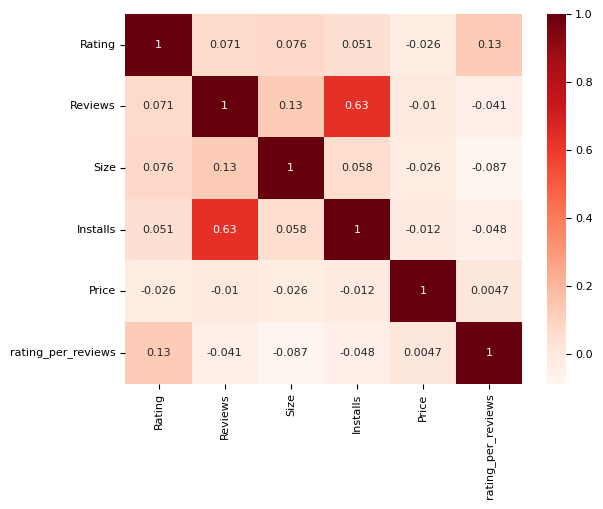

In [ ]:

# strat_train_set["rating_per_price"] = strat_train_set["Rating"] / strat_train_set["Price"]
strat_train_set["rating_per_reviews"] = strat_train_set["Rating"] / strat_train_set["Reviews"]


sns.heatmap( strat_train_set.corr(), annot=True, cmap='Reds')

In [ ]:
nullcount(strat_train_set)

{'Category': 0,
 'Rating': 0,
 'Reviews': 0,
 'Size': 0,
 'Installs': 0,
 'Type': 0,
 'Price': 0,
 'Content Rating': 0,
 'Genres': 0,
 'rating_cat': 0,
 'Genres_2': 0,
 'rating_per_reviews': 0}

#Handling Text and Categorical Attributes

In [ ]:
app_cat = strat_train_set[["Category","Type", "Content Rating","Genres","Genres_2" ]]


In [ ]:

cat_encoder = OneHotEncoder()
app_cat_1hot = cat_encoder.fit_transform(app_cat)

In [ ]:
cat_encoder.feature_names_in_

array(['Category', 'Type', 'Content Rating', 'Genres', 'Genres_2'],
      dtype=object)

In [ ]:
app_num = strat_train_set.select_dtypes(include=[np.number])

In [ ]:


min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
app_num_min_max_scaled = min_max_scaler.fit_transform(app_num)

In [ ]:


std_scaler = StandardScaler()
app_num_std_scaled = std_scaler.fit_transform(app_num)

In [ ]:
strat_train_set[strat_train_set["Price"]==np.inf]

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,rating_cat,Genres_2,rating_per_reviews


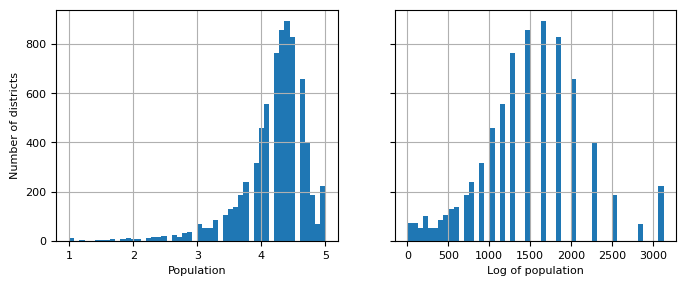

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
strat_train_set["Rating"].hist(ax=axs[0], bins=50)
strat_train_set["Rating"].apply(lambda x: np.power(x,5)).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

In [ ]:
strat_train_set.skew().sort_values(ascending=False)

<ipython-input-273-ca541927dd29>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  strat_train_set.skew().sort_values(ascending=False)


Price                 25.376279
Reviews               15.017211
Installs               8.812788
rating_per_reviews     7.395923
Size                   1.553876
Rating                -1.863356
dtype: float64

In [ ]:
strat_train_set.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,rating_cat,Genres_2,rating_per_reviews
1653,GAME,4.5,4447388,6.700000e+07,100000000,Free,0.0,Everyone 10+,Adventure,5,Adventure,0.000001
3767,NEWS_AND_MAGAZINES,4.4,1284017,1.316241e+07,500000000,Free,0.0,Everyone 10+,News & Magazines,5,News & Magazines,0.000003
1175,FINANCE,4.1,6998,2.400000e+07,1000000,Free,0.0,Everyone,Finance,5,Finance,0.000586
3088,SPORTS,4.3,7543,2.500000e+07,500000,Free,0.0,Everyone,Sports,5,Sports,0.000570
3947,FAMILY,3.9,31061,8.300000e+07,1000000,Free,0.0,Everyone,Health & Fitness,4,Health & Fitness,0.000126


# Pipeline

In [ ]:

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standerdize", StandardScaler())
]) 

In [ ]:
set_config(display='diagram')
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standerdize', StandardScaler())])

In [ ]:
appdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   App             9360 non-null   object  
 1   Category        9360 non-null   object  
 2   Rating          9360 non-null   float64 
 3   Reviews         9360 non-null   object  
 4   Size            9360 non-null   object  
 5   Installs        9360 non-null   object  
 6   Type            9360 non-null   object  
 7   Price           9360 non-null   object  
 8   Content Rating  9360 non-null   object  
 9   Genres          9360 non-null   object  
 10  Last Updated    9360 non-null   object  
 11  Current Ver     9360 non-null   object  
 12  Android Ver     9360 non-null   object  
 13  rating_cat      9360 non-null   category
dtypes: category(1), float64(1), object(12)
memory usage: 1.3+ MB


In [ ]:
num_attribs = [i for i in strat_train_set.select_dtypes(include="number").columns]
cat_attribs = [i for i in strat_train_set.select_dtypes(include=object).columns]

num_attribs, cat_attribs

(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'rating_per_reviews'],
 ['Category', 'Type', 'Content Rating', 'Genres', 'Genres_2'])

In [ ]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

def clean_data_num(X):

  
  X=pd.DataFrame(X, columns= ["Installs",'Price', "Reviews"])

  print(X.info())

  # Convert 'Installs' column
  X["Installs"] = X["Installs"].apply(lambda x: int(str(x).split("+")[0].replace(",", "")) if x != "Free" else 0)
  
  # Replace 'Size' column values
  
  # Convert 'Reviews' column
  X["Reviews"] = X["Reviews"].apply(lambda x: int(x))

  # Convert 'Price' column
  X["Price"] = X["Price"].apply(lambda x: float(x.replace("$", "")) if x != "Free" else 0)


  # Drop unnecessary columns
  # X.drop(['App', 'Last Updated', 'Current Ver', 'Android Ver'], axis=1, inplace=True)
  return X



def clean_data_cat(X):

    X=pd.DataFrame(X, columns= ['Category', 'Genres', 'Size'])
    X["Size"].replace('Varies with device', np.nan, inplace=True)
    X["Size"] = (
        X["Size"].replace(r'[kM]+$', '', regex=True).astype(float) *
        X["Size"].str.extract(r'[\d\.]+([KM]+)', expand=False)
        .fillna(1)
        .replace(['k', 'M'], [10 ** 3, 10 ** 6]).astype(int)
    )

    # Fill missing 'Size' values with mean based on 'Category'
    X['Size'].fillna(X.groupby('Category')['Size'].transform('mean'), inplace=True)

    # Extract primary genre from 'Genres' column
    X["Genres"] = X["Genres"].apply(lambda x: x.split(";")[0])

    # Extract secondary genre from 'Genres' column
    X["Genres_2"] = X["Genres"].apply(lambda x: x.split(";")[-1])

    return X
  

In [ ]:
clean_pipeline_num= make_pipeline(
        # SimpleImputer(strategy="median"),
        FunctionTransformer(clean_data_num, feature_names_out="one-to-one"),
        StandardScaler()) 

clean_pipeline_cat=make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        FunctionTransformer(clean_data_cat, feature_names_out="one-to-one"),
        ) 
clean_pipeline = make_pipeline(
        clean_pipeline_num,
        clean_pipeline_cat
)

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

pow_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=True))
])

In [ ]:
preprocessing = ColumnTransformer([
    ("clean", clean_pipeline, ['Category', 'Type', 'Content Rating', 'Genres', 'Size', 'Price', "Reviews"]),
    ("rating/reviews", ratio_pipeline(), ["Rating", "Reviews"]),
    ("log", pow_pipeline, num_attribs),
    
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
],
    remainder=default_num_pipeline) 

app_prepared = preprocessing.fit_transform(appdata)


In [ ]:
appdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   App             9360 non-null   object  
 1   Category        9360 non-null   object  
 2   Rating          9360 non-null   float64 
 3   Reviews         9360 non-null   object  
 4   Size            9360 non-null   object  
 5   Installs        9360 non-null   object  
 6   Type            9360 non-null   object  
 7   Price           9360 non-null   object  
 8   Content Rating  9360 non-null   object  
 9   Genres          9360 non-null   object  
 10  Last Updated    9360 non-null   object  
 11  Current Ver     9360 non-null   object  
 12  Android Ver     9360 non-null   object  
 13  rating_cat      9360 non-null   category
dtypes: category(1), float64(1), object(12)
memory usage: 1.3+ MB


In [ ]:
app_data = strat_train_set.drop(["Rating"], axis=1)
app_labels = strat_train_set["Rating"]

#Select and Train a Model

## Training and Evaluating on the Training Set

In [ ]:

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X, y)

In [ ]:
rating_predictions = lin_reg.predict(strat_test_set)

In [ ]:

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'random_forest__max_features': [4, 6, 8]},
    {'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(app_data, app_labels)

In [ ]:
grid_search.best_params_s

In [ ]:

param_distribs = {'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(app_data, app_labels)

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)